# <span style="color:blue;">Second Project<span>
### <span style="background-color:blue; color:yellow">Brain Stroke Risk Prediction<span>
#### <span style="color:red">Taken from Kaggle<span>

- ברצוני לציין שלמרות שה
  <br>
dataset
<br> 
הוא יחסית פשוט (ופחות מעניין) אבל זה איפשר לי להבין ככה יותר את ה
<br>
FLOW
<br>
של התהליך ואת הסדר
<br>
על מנת להתמודד עם דטא יותר מאתגר בעתיד
<br>
בחרתי להתמקד בתהליך הלמידה בדברים הטכניים
<br>
ובמשהו שיאפשר לי להבין את התוצאות בצורה כזו שאוכל לממש את מה שהבנתי גם על נתונים מסוכבים יותר בעתיד
<br>


## Some Information about Brain Stroke

<b>Definition</b>: A stroke occurs when poor blood flow to the brain leads to cell death.

<b>Types:</b>

<b>Ischemic stroke</b>: Caused by lack of blood flow due to a blocked blood vessel.

<b>Hemorrhagic stroke</b>: Caused by bleeding in or around the brain.

<b>Symptoms:</b>

- Inability to move or feel on one side of the body.

- Difficulty speaking or understanding speech.

- Dizziness or vision loss on one side.

- Severe headache (more common in hemorrhagic strokes).

- Symptoms often appear quickly and can be permanent.

<b>Transient Ischemic Attack (TIA):</b>

- Also known as a mini-stroke.

- Symptoms last less than 1–2 hours.

<b>Complications:</b>

- Long-term issues may include pneumonia and loss of bladder control.

<b>Risk Factors:</b>

- High blood pressure (main risk factor).

- High cholesterol, smoking, obesity, diabetes, previous TIA, kidney disease, atrial fibrillation.

<b>Causes:</b>

- Ischemic: Blood vessel blockage.

- Hemorrhagic: Bleeding from a ruptured aneurysm or between brain membranes.

<b>Diagnosis:</b>(Based on physical exam, CT scan, MRI.)

- CT rules out bleeding but may not show ischemia early.

- ECG and blood tests help identify risk factors and rule out other causes (e.g., low blood sugar).

<b>Prevention:</b>

- Manage risk factors (e.g., high blood pressure).

- Surgery for carotid artery narrowing.

- Medications like warfarin (for atrial fibrillation), aspirin, or statins.

<b>Treatment:</b>

- Emergency care is critical.

- Ischemic strokes may be treated with clot-dissolving medication within 3–4.5 hours.

- Some hemorrhagic strokes may require surgery.

- Stroke rehabilitation aims to recover lost function and is ideally provided in specialized stroke units

### Features Information
1) <b>gender:</b> "Male", "Female" or "Other"

2) <b>age:</b> age of the patient

3) <b>hypertension:</b> 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

4) <b>heart disease:</b> 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease 5) Ever-married: "No" or "Yes"

6) <b>work type:</b> "children", "Govtjov", "Never worked", "Private" or "Self-employed"

7) <b>Residencetype:</b> "Rural" or "Urban"

8) <b>avg glucose level:</b> average glucose level in blood

9) <b>BMI:</b> body mass index

10) <b>smoking_status:</b> "formerly smoked", "never smoked", "smokes" or "Unknown"*

11) <b>stroke:</b> 1 if the patient had a stroke or 0 if not

## Imports

In [2]:
# please install xgboost   => pip install xgboost

  Using cached xgboost-3.0.0-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-win_amd64.whl (150.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import joblib
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from kaggle.api.kaggle_api_extended import KaggleApi
import os

## classes

#### static DataPreprocessor

In [4]:
class Preprocessor:

    @staticmethod
    def fill_missing(df):
        """Fill numerical columns with median, categorical with mode."""
        df = df.copy()
        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                print(f"Apply median to column {col}")
                df[col] = df[col].fillna(df[col].median())
            else:
                if df[col].mode().empty:
                    df[col] = df[col].fillna("Unknown")
                    print(f"Found empty rows in column {col}, changed to 'Unknown'")
                else:
                    print(f"Apply mode to column {col}")
                    df[col] = df[col].fillna(df[col].mode()[0])
        print("fill_missing terminated successfully")
        return df

    @staticmethod
    def detect_outliers_iqr(df):
        """Mark outliers in numerical columns based on IQR."""
        df = df.copy()
        for col in df.select_dtypes(include=np.number):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = ~((df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR))
            df[col + '_outlier'] = mask.astype(int)
        print("detect_outliers_iqr terminated successfully")
        return df

    @staticmethod
    def encode_one_hot_categorical(df, columns):
        """One-hot encode specified categorical columns."""
        df = df.copy()
        df = pd.get_dummies(df, columns=columns, drop_first=True)
        bool_cols = df.select_dtypes(include='bool').columns
        df[bool_cols] = df[bool_cols].astype(int)
        print("encode_one_hot_categorical terminated successfully")
        return df


    @staticmethod
    def encode_label_categorical(df, categorical_cols):
        label_encoders = {}
        df_encoded = df.copy()
    
        for col in categorical_cols:
            le = LabelEncoder()
            le.fit(df_encoded[col])
            df_encoded[col] = le.transform(df_encoded[col])
            label_encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    
        return df_encoded, label_encoders
        
    @staticmethod
    def scale_features(df, cols):
        """Standardize numerical features using StandardScaler."""
        df = df.copy()
        scaler = StandardScaler()
        df[cols] = scaler.fit_transform(df[cols])
        print("scale_features terminated successfully")
        return df

    @staticmethod
    def split_to_train_test(df, target_column, test_size=0.2, random_state=42):
        """Split the dataset into train and test sets with stratification."""
        X = df.drop(columns=[target_column])
        y = df[target_column]
        return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    @staticmethod
    def explore_data(df):
        """Run some basic EDA commands."""
        print("First 5 rows:\n", df.head())
        print("__________________________________________")
        print("\nShape of the DataFrame:", df.shape)
        print("__________________________________________")
        print("\nColumns:\n", df.columns.tolist())
        print("__________________________________________")
        print("\nInfo:")
        df.info()
        print("__________________________________________")
        print("\nData Types:\n", df.dtypes)
        print("__________________________________________")
        print("\nUnique values per column:\n", df.nunique())
        print("__________________________________________")
        print("\ndescribe:\n", df.describe())
        print("__________________________________________")
        print("\nMissing Values:\n", df.isnull().sum())
        print("__________________________________________")

    @staticmethod
    def prepare_for_corr(df):
        return df.select_dtypes(include=['number'])

    @staticmethod
    def heatmap_correlation(df):
        numeric_features = DataPreprocessor.prepare_for_corr(df)
        corr_matrix = numeric_features.corr()
        plt.figure(figsize=(10, 8)) 
        sns.heatmap(corr_matrix, annot=True, cmap='Blues')
        plt.title('Correlation Matrix')
        plt.show()
        
    @staticmethod    
    def plot_distributions(df, columns_config):
        """
        Generates distribution plots (histograms with KDE) for specified columns in a DataFrame,
        allowing for custom colors for each plot.
        """
        sns.set(style="whitegrid")
        num_plots = len(columns_config)
        fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))
        axes = axes.flatten() 
    
        for i, config in enumerate(columns_config):
            col = config.get('name')
            color = config.get('color')
    
            if col in df.columns:
                sns.histplot(df[col], kde=True, bins=30, ax=axes[i], color=color if color else 'skyblue')
                axes[i].set_title(f'{col.capitalize()} Distribution')
                axes[i].set_xlabel(col.capitalize())
            else:
                print(f"Warning: Column '{col}' not found in the DataFrame.")
    
        plt.tight_layout()
        plt.show()


#### Classifaier

In [38]:
class Classifier:
    @staticmethod
    def evaluate_model(model, X_train, X_test, y_train, y_test):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Compute AUC only if model supports predict_proba
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
        else:
            auc = "N/A"

        print(f"Model: {model.__class__.__name__}")
        print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
        print(f"Precision: {precision_score(y_test, y_pred):.4f}")
        print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
        print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
        print(f"AUC Score: {auc}")
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Confusion Matrix: {model.__class__.__name__}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()


#### Utils

In [5]:
#os.environ['KAGGLE_USERNAME'] = 'itsikedrisalesmen'
#os.environ['KAGGLE_KEY'] = '2c3138465ece45b1f9adf1f2d455a0a6'

class Utils:
    @staticmethod
    def load_csv(path):
        """Load a CSV file and return a DataFrame."""
        return pd.read_csv(path)

    @staticmethod
    def download_kaggle_dataset(dataset_url: str, download_path: str = "datasets", unzip: bool = True):
        """
        Downloads a Kaggle dataset using the Kaggle API.

        Parameters:
        - dataset_url: str → e.g., "sebastianwillmann/beverage-sales"
        - download_path: str → folder to download the dataset into
        - unzip: bool → whether to unzip the dataset after downloading
        """
        os.makedirs(download_path, exist_ok=True)

        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files(dataset_url, path=download_path, unzip=unzip)

        print(f"✅ Dataset downloaded to: {os.path.abspath(download_path)}")


## Data prep and EDA

In [6]:
path = "./brain_stroke.csv"
brain_stroke = Utils.load_csv(path)
Preprocessor.explore_data(brain_stroke)

First 5 rows:
    gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self-employed   
4    Male  81.0             0              0          Yes        Private   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             105.92  32.5     never smoked       1  
2          Urban             171.23  34.4           smokes       1  
3          Rural             174.12  24.0     never smoked       1  
4          Urban             186.21  29.0  formerly smoked       1  
__________________________________________

Shape of the DataFrame: (4981, 11)
___________________________________

### Insights from first look at the data
- dataset has 4,981 records and 11 features
- <b>Categorical:</b> gender, ever_married, work_type, Residence_type, smoking_status
- <b>Numerical:</b> age, avg_glucose_level, bmi
- <b>Binary (0/1):</b> hypertension, heart_disease, stroke (target)
- No missing values detected in the dataset
- <b>ever_married</b>,<b>gender</b> and <b>Residence_type</b> has only 2 options - might change to 0 or 1  - <b>will be checked and considered</b>
- <b>work_type</b> and <b>smoking_status</b> has  4 option - might be encode - <b>will be checked and considered</b> 
- age is between 1 monthes old and 82 years - 1 months might not make sense in this stroke prediction - <b>age might be changed to segments</b>
- very wide spread of ages, from infants to seniors
- 75th Percentile: 61 years — suggests a higher elderly portion.

In [7]:
categorical_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

### Distributions

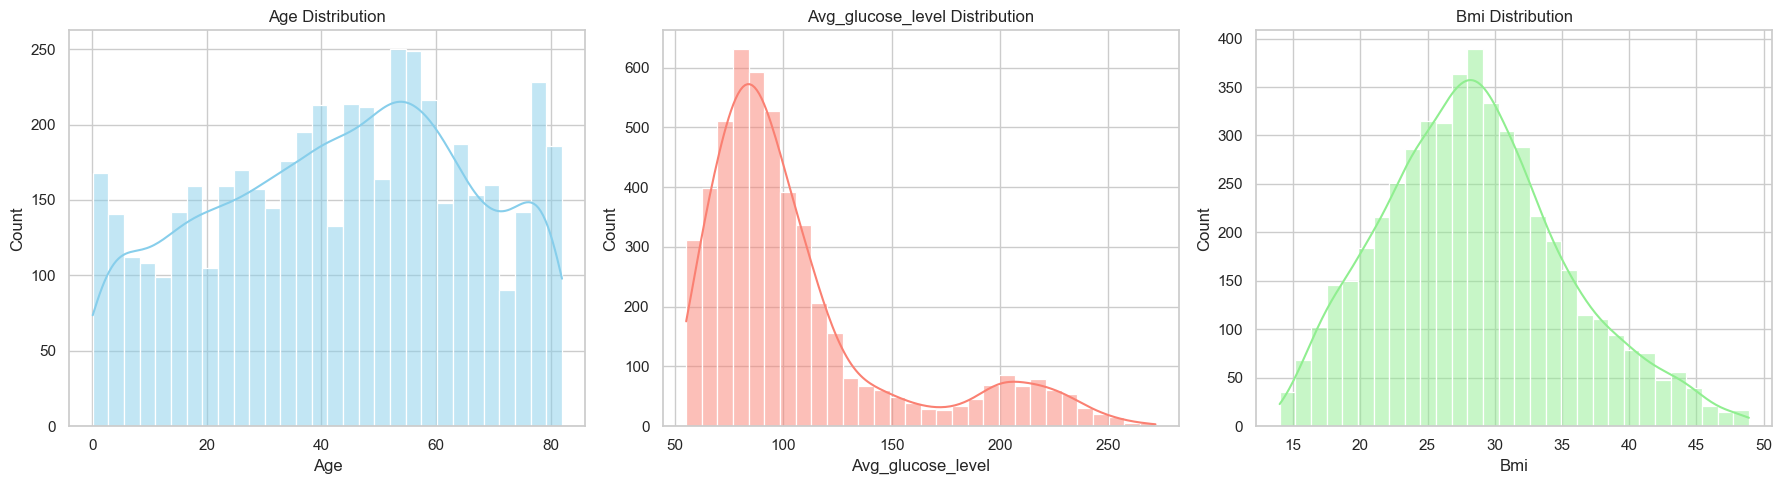

In [8]:
columns_to_plot_config = [
    {'name': 'age', 'color': 'skyblue'},
    {'name': 'avg_glucose_level', 'color': 'salmon'},
    {'name': 'bmi', 'color': 'lightgreen'}
]
Preprocessor.plot_distributions(brain_stroke, columns_to_plot_config)

#### what we learn from the distribution plots
 1. glucose and BMI are right-skewed and Age has wide diversity(range):
    - Age: Mean 43, max 82.
    - Glucose: Up to 272 mg/dL.
    - BMI: Mean 28.5, ranges from 14 to 49.
    - right-skewed indicates most samples have typical values, only few samples have very high glucose or BMI
#### consideration:
  - check for <b>outliers</b> and maybe remove them
  - consider <b>standardize</b> 

### CROSSTABS

In [15]:

# Load the dataset
df = pd.read_csv("brain_stroke.csv")

# Basic Crosstab: Stroke by Gender
ct_gender = pd.crosstab(df['gender'], df['stroke'], margins=True, normalize='index')
print("\nStroke Rate by Gender:")
print(ct_gender)

# Stroke by Work Type
ct_work = pd.crosstab(df['work_type'], df['stroke'], margins=True, normalize='index')
print("\nStroke Rate by Work Type:")
print(ct_work)

# Stroke by Smoking Status
ct_smoking = pd.crosstab(df['smoking_status'], df['stroke'], margins=True, normalize='index')
print("\nStroke Rate by Smoking Status:")
print(ct_smoking)

# Stroke by Hypertension
ct_hypertension = pd.crosstab(df['Residence_type'], df['stroke'], margins=True, normalize='index')
print("\nStroke Rate by Residence_type:")
print(ct_hypertension)

# Stroke by Heart Disease
ct_heart = pd.crosstab(df['heart_disease'], df['stroke'], margins=True, normalize='index')
print("\nStroke Rate by Heart Disease:")
print(ct_heart)



Stroke Rate by Gender:
stroke         0         1
gender                    
Female  0.951840  0.048160
Male    0.947927  0.052073
All     0.950211  0.049789

Stroke Rate by Work Type:
stroke                0         1
work_type                        
Govt_job       0.948758  0.051242
Private        0.948252  0.051748
Self-employed  0.919154  0.080846
children       0.997028  0.002972
All            0.950211  0.049789

Stroke Rate by Smoking Status:
stroke                  0         1
smoking_status                     
Unknown          0.968667  0.031333
formerly smoked  0.919262  0.080738
never smoked     0.951578  0.048422
smokes           0.945876  0.054124
All              0.950211  0.049789

Stroke Rate by Residence_type:
stroke                 0         1
Residence_type                    
Rural           0.953859  0.046141
Urban           0.946682  0.053318
All             0.950211  0.049789

Stroke Rate by Heart Disease:
stroke                0         1
heart_disease       

### correlation (Pearson)

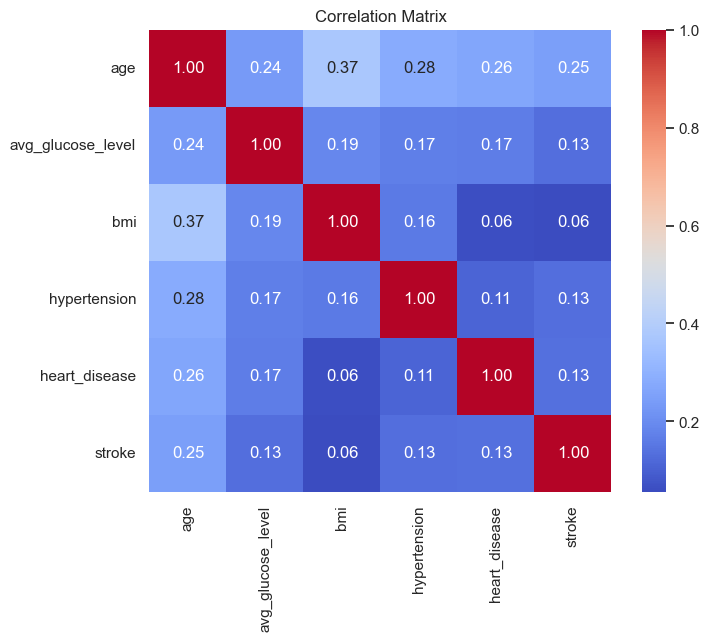

In [9]:
numerical_cols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease', 'stroke']
corr_matrix = brain_stroke[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()

- No feature has strong linear correlation with stroke, but age shows a bit more influential than others.

### correlation (kendall)

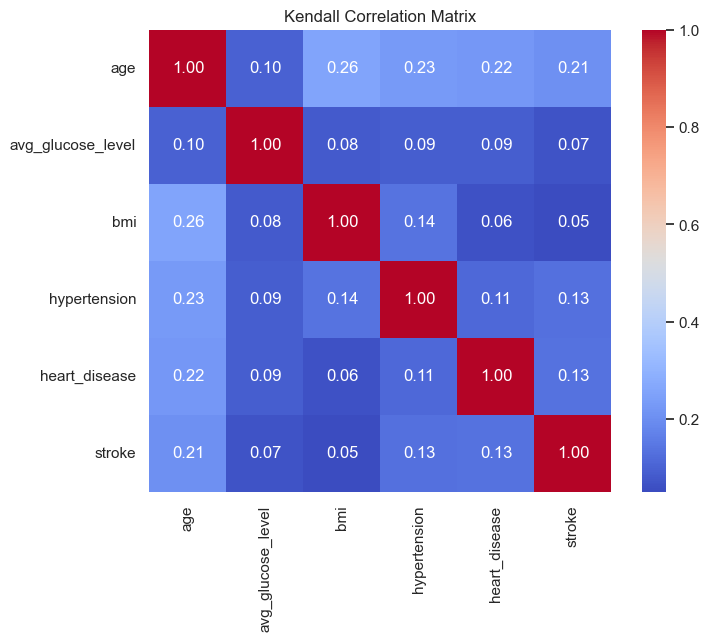

In [10]:
kendall_corr_matrix = brain_stroke[numerical_cols].corr(method='kendall')

plt.figure(figsize=(8, 6))
sns.heatmap(kendall_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Kendall Correlation Matrix')
plt.show()

- with Kendall also No feature has strong correlation 

### categorical features & stroke visualization

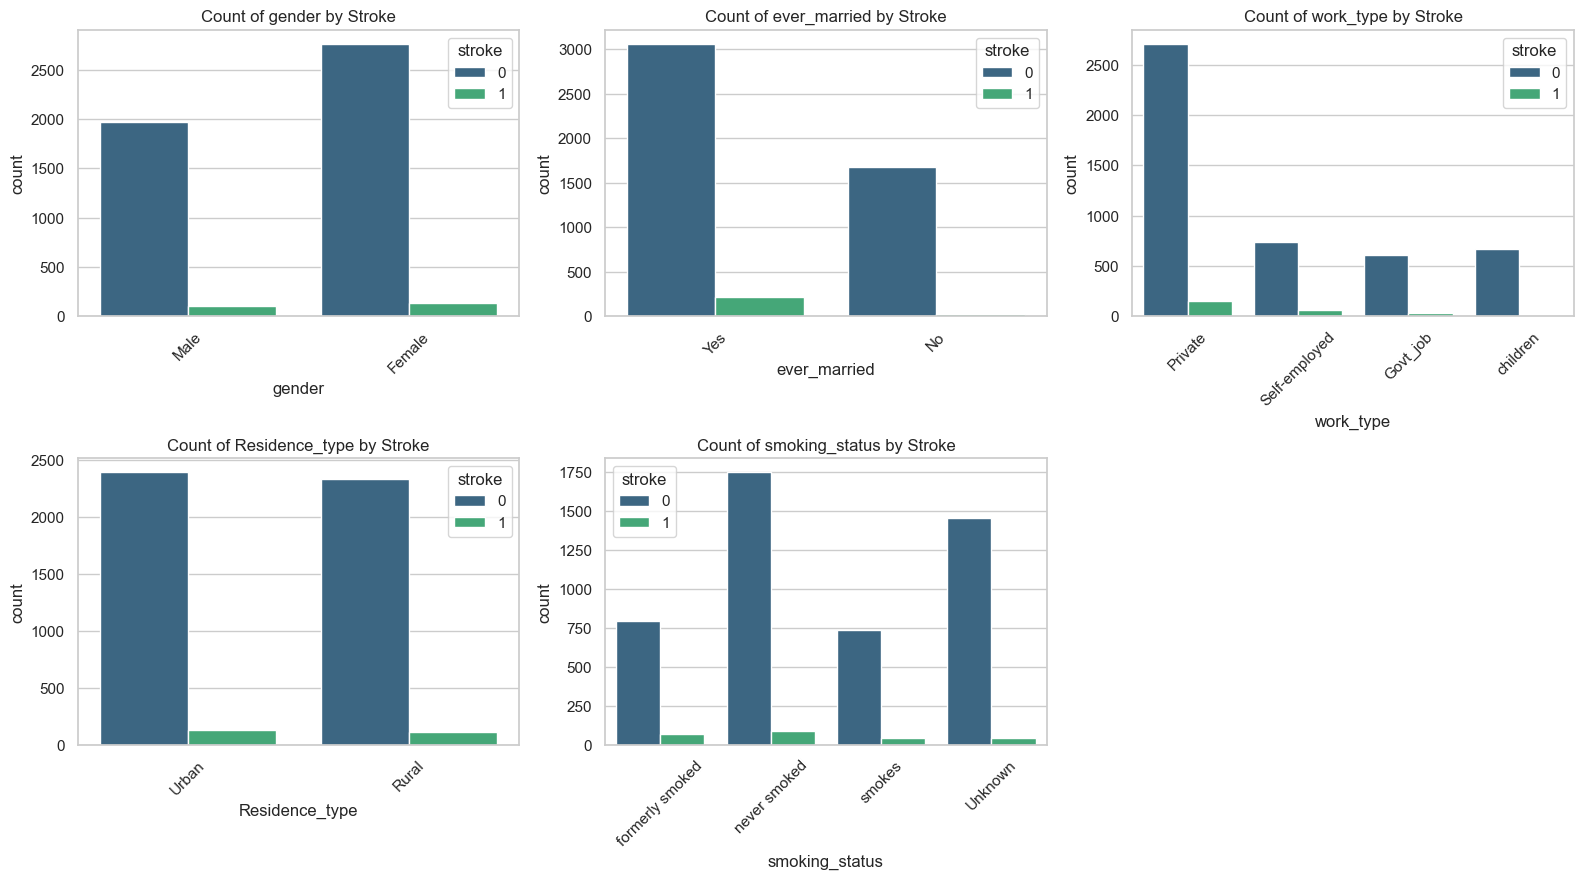

In [11]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=brain_stroke[col], hue=brain_stroke["stroke"], palette="viridis")
    plt.title(f"Count of {col} by Stroke")
    plt.xticks(rotation=45)  # Rotate labels for better readability

plt.tight_layout()
plt.show()

### binary features & stroke visualization

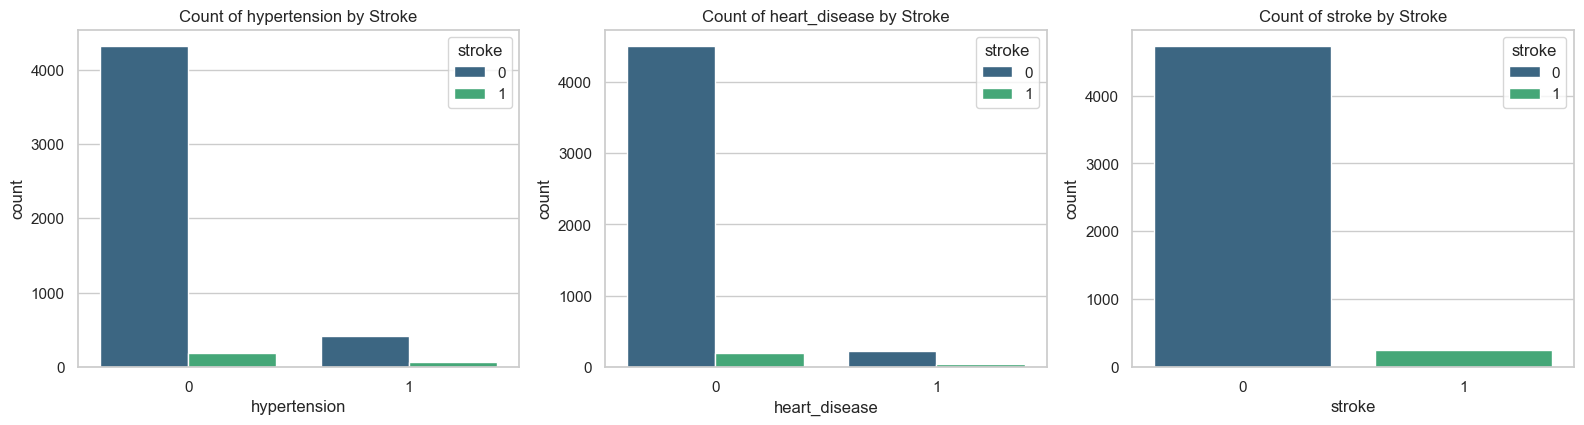

In [12]:
binary_cols = ["hypertension", "heart_disease", "stroke"]
plt.figure(figsize=(16, 12))
for i, col in enumerate(binary_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=brain_stroke[col], hue=brain_stroke["stroke"], palette="viridis")
    plt.title(f"Count of {col} by Stroke")

plt.tight_layout()
plt.show()

### Stroke Distribution by smoking status

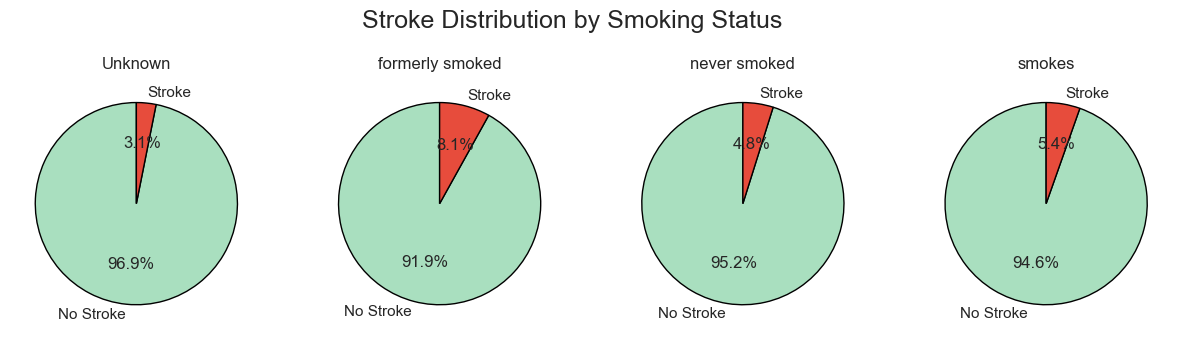

In [13]:
custom_colors = ["#A9DFBF", "#E74C3C"]
smoking_stroke_counts = brain_stroke.groupby("smoking_status")["stroke"].value_counts().unstack()
fig, axes = plt.subplots(1, len(smoking_stroke_counts), figsize=(15, 4))

for i, smoking_status in enumerate(smoking_stroke_counts.index):
    axes[i].pie(
        smoking_stroke_counts.loc[smoking_status], 
        labels=["No Stroke", "Stroke"], 
        autopct="%1.1f%%", 
        colors=custom_colors,
        startangle=90,
        wedgeprops={"edgecolor": "black"}
    )
    axes[i].set_title(f"{smoking_status}")
plt.suptitle("Stroke Distribution by Smoking Status", fontsize=18)
plt.show()

### Stroke Distribution by Married status

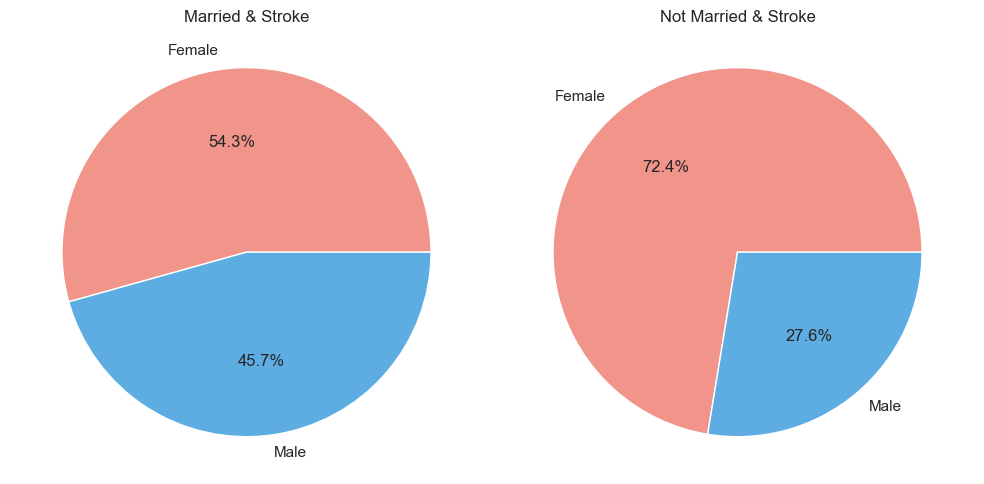

In [14]:
married_stroke = brain_stroke[(brain_stroke["ever_married"] == "Yes") & (brain_stroke["stroke"] == 1)]
not_married_stroke = brain_stroke[(brain_stroke["ever_married"] == "No") & (brain_stroke["stroke"] == 1)]

gender_counts = married_stroke["gender"].value_counts()
gender_counts2 = not_married_stroke["gender"].value_counts()

gender_palette = {
    "Male": "#5DADE2",    # blue
    "Female": "#F1948A",  # pink/red
    "Other": "#BB8FCE"    # purple
}

plt.figure(figsize=(10, 5))

# Married
plt.subplot(1, 2, 1)
labels1 = gender_counts.index
colors1 = [gender_palette[label] for label in labels1]
plt.pie(gender_counts, labels=labels1, autopct='%1.1f%%', colors=colors1)
plt.title("Married & Stroke")
plt.axis("equal")

# Not Married
plt.subplot(1, 2, 2)
labels2 = gender_counts2.index
colors2 = [gender_palette[label] for label in labels2]
plt.pie(gender_counts2, labels=labels2, autopct='%1.1f%%', colors=colors2)
plt.title("Not Married & Stroke")
plt.axis("equal")

plt.tight_layout()
plt.show()

In [15]:
married_female_stroke = brain_stroke[
    (brain_stroke['gender'] == 'Female') &
    (brain_stroke['ever_married'] == 'Yes') &
    (brain_stroke['stroke'] == 1)
]
total_married_female_stroke = len(married_female_stroke)
print("Total married females with stroke:", total_married_female_stroke)

married_female_stroke = brain_stroke[
    (brain_stroke['gender'] == 'Male') &
    (brain_stroke['ever_married'] == 'Yes') &
    (brain_stroke['stroke'] == 1)
]
total_married_female_stroke = len(married_female_stroke)
print("Total married male with stroke:", total_married_female_stroke)

married_female_stroke = brain_stroke[
    (brain_stroke['gender'] == 'Female') &
    (brain_stroke['ever_married'] == 'No') &
    (brain_stroke['stroke'] == 1)
]
total_married_female_stroke = len(married_female_stroke)
print("Total single females with stroke:", total_married_female_stroke)

married_female_stroke = brain_stroke[
    (brain_stroke['gender'] == 'Male') &
    (brain_stroke['ever_married'] == 'No') &
    (brain_stroke['stroke'] == 1)
]
total_married_female_stroke = len(married_female_stroke)
print("Total single male with stroke:", total_married_female_stroke)

Total married females with stroke: 119
Total married male with stroke: 100
Total single females with stroke: 21
Total single male with stroke: 8


- out of 248 stroke cases in the dataset:
  * 46% married males (100) and 55 married females(119)
  * 27% not married males (8) and 72 not married female (21)
- married males are with higher chance to stroke (something we already knew before :))
- not Married females are with higer chance to stroke

## Feature engineering

### Age Segments

In [16]:
age_segments = [0, 15, 30, 50, 65, 100]
age_labels = ['Child (0 ≤ age < 15)', 'Young Adult (15 ≤ age < 30)', 'Adult (30 ≤ age < 50)', 'Senior (50 ≤ age < 65)', 'Elderly (65+)']
brain_stroke['age_group'] = pd.cut(brain_stroke['age'], bins=age_segments, labels=age_labels, right=False)
group_totals = brain_stroke['age_group'].value_counts().sort_index()
group_totals

age_group
Child (0 ≤ age < 15)            679
Young Adult (15 ≤ age < 30)     787
Adult (30 ≤ age < 50)          1342
Senior (50 ≤ age < 65)         1153
Elderly (65+)                  1020
Name: count, dtype: int64

In [17]:
group_strokes = brain_stroke[brain_stroke['stroke'] == 1]['age_group'].value_counts().sort_index()
summary = pd.DataFrame({
    'Total': group_totals,
    'Stroke Cases': group_strokes,
})
summary['Prevalence (%)'] = (summary['Stroke Cases'] / summary['Total'] * 100).round(2)
summary['Formatted'] = summary.apply(lambda row: f"{row['Stroke Cases']} out of {row['Total']}", axis=1)
print(summary[['Formatted', 'Prevalence (%)']])

                                       Formatted  Prevalence (%)
age_group                                                       
Child (0 ≤ age < 15)            2.0 out of 679.0            0.29
Young Adult (15 ≤ age < 30)     0.0 out of 787.0            0.00
Adult (30 ≤ age < 50)         17.0 out of 1342.0            1.27
Senior (50 ≤ age < 65)        70.0 out of 1153.0            6.07
Elderly (65+)                159.0 out of 1020.0           15.59


- Since Child and Young Adult segments are negligible - I decided to remove them

#### removing age 0-30

In [18]:
brain_stroke_30_plus = brain_stroke[~brain_stroke['age_group'].isin(['Child (0 ≤ age < 15)', 'Young Adult (15 ≤ age < 30)'])].copy()
print(brain_stroke_30_plus['age_group'].value_counts())

age_group
Adult (30 ≤ age < 50)          1342
Senior (50 ≤ age < 65)         1153
Elderly (65+)                  1020
Child (0 ≤ age < 15)              0
Young Adult (15 ≤ age < 30)       0
Name: count, dtype: int64


In [19]:
brain_stroke_30_plus.shape

(3515, 12)

- 3515 rows left after removing Child and Young Adults age groups

## Prevalence (before removing young age 0-30)

In [20]:
print("Stroke cases:", brain_stroke["stroke"].sum())

Stroke cases: 248


In [21]:
brain_stroke_percentage = (248 / 4981) * 100
print(f"Stroke prevalence: {brain_stroke_percentage:.2f}%")

Stroke prevalence: 4.98%


- only 5% of patients have had a stroke, indicating a class <b>imbalance</b>. => <b>consider SMOTE!! after train-test split</b>

#### prevalence by age plot

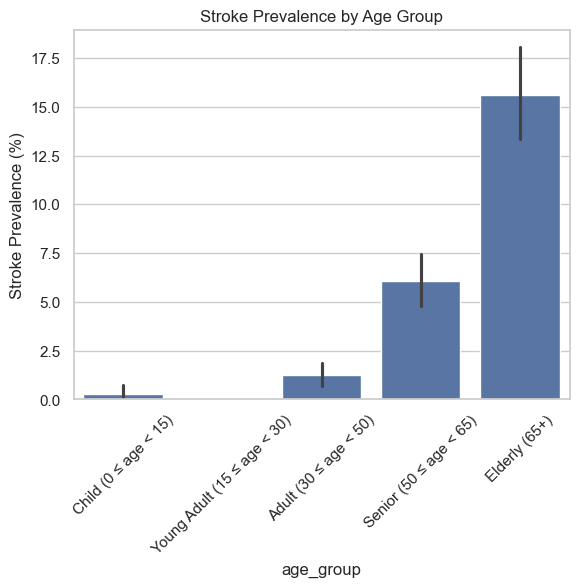

In [22]:
sns.barplot(
    data=brain_stroke,
    x="age_group", y="stroke", estimator=lambda x: sum(x)/len(x)*100
)
plt.ylabel("Stroke Prevalence (%)")
plt.title("Stroke Prevalence by Age Group")
plt.xticks(rotation=45)
plt.show()

## Prevalence (after removing young age 0-30)

In [23]:
print("Stroke cases:", brain_stroke_30_plus["stroke"].sum())

Stroke cases: 246


In [24]:
brain_stroke_30_percentage = (246 / 3515) * 100
print(f"Stroke prevalence: {brain_stroke_30_percentage:.2f}%")

Stroke prevalence: 7.00%


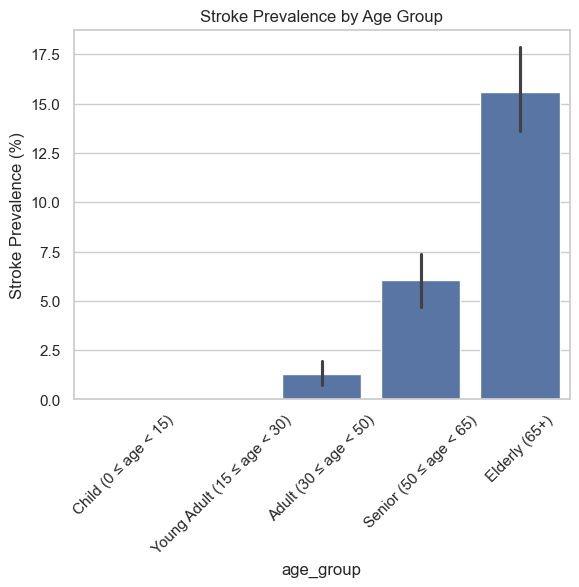

In [25]:
sns.barplot(
    data=brain_stroke_30_plus,
    x="age_group", y="stroke", estimator=lambda x: sum(x)/len(x)*100
)
plt.ylabel("Stroke Prevalence (%)")
plt.title("Stroke Prevalence by Age Group")
plt.xticks(rotation=45)
plt.show()

## Train/Test

In [26]:
X_train, X_test, y_train, y_test = Preprocessor.split_to_train_test(brain_stroke_30_plus,target_column="stroke")

## Impute missing data and special value and encode

- no need to impute - no missing data found in the dataset
- no special value

### Encode (labelEncoder)

In [27]:
label_encoding_cols = ["gender", "ever_married", "Residence_type"]
X_train_encoded, encoders = Preprocessor.encode_label_categorical(X_train, categorical_cols)

# Apply same encoders to test set
X_test_encoded = X_test.copy()
for col, mapping in encoders.items():
    X_test_encoded[col] = X_test_encoded[col].map(mapping)

### Encode (one hot)

In [28]:
one_hot_encoding_cols = ['work_type', 'smoking_status']
X_train_encoded = Preprocessor.encode_one_hot_categorical(X_train_encoded, columns=one_hot_encoding_cols)
X_test_encoded = Preprocessor.encode_one_hot_categorical(X_test_encoded, columns=one_hot_encoding_cols)

# Align columns (critical!)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

encode_one_hot_categorical terminated successfully
encode_one_hot_categorical terminated successfully


## Normalize and standardization

### Scaling

In [29]:
cols_to_scale = ['age', 'avg_glucose_level', 'bmi']
X_train_encoded = Preprocessor.scale_features(X_train_encoded, cols_to_scale)
X_test_encoded = Preprocessor.scale_features(X_test_encoded, cols_to_scale)

scale_features terminated successfully
scale_features terminated successfully


### drop age_group col

In [ ]:
X_train_encoded = X_train_encoded.drop(columns=['age_group'])
X_test_encoded = X_test_encoded.drop(columns=['age_group'])

### SMOTE

In [42]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)
print(Counter(y_train_resampled))

Counter({0: 2615, 1: 2615})


-  training data (y_train_resampled) now has 2,615 examples of class 0 (no stroke) and 2,615 examples of class 1 (Stroke) — it's now balanced.

### this is how the data looks before run modles

In [37]:
X_train_resampled.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_1,work_type_2,smoking_status_1,smoking_status_2,smoking_status_3
0,0,1.731763,1,0,1,1,2.133530,2.153379,0,0,0,1,0
1,1,1.798808,0,0,1,0,-0.483572,-0.149294,1,0,1,0,0
2,0,1.530629,0,1,1,1,-0.067909,-0.364652,1,0,0,1,0
3,0,-0.882977,0,0,0,1,-0.612557,-0.248690,1,0,0,1,0
4,0,0.524960,0,0,1,1,-0.336796,0.728703,0,1,0,0,0


## Models

------------------/////////  LogisticRegression(max_iter=1000)  ////////---------
Model: LogisticRegression
Accuracy:  0.7055
Precision: 0.1343
Recall:    0.5918
F1 Score:  0.2189
AUC Score: 0.7346314672658054

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.71      0.82       654
           1       0.13      0.59      0.22        49

    accuracy                           0.71       703
   macro avg       0.55      0.65      0.52       703
weighted avg       0.90      0.71      0.78       703



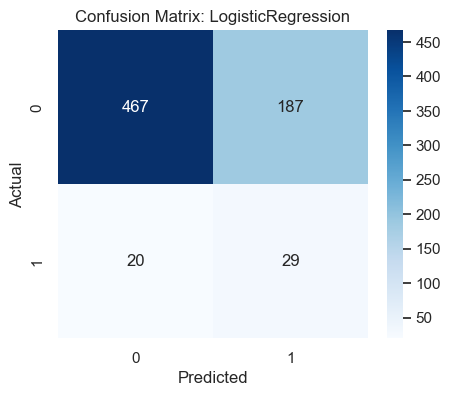

**********************************************************************************************
------------------/////////  SVC(probability=True)  ////////---------
Model: SVC
Accuracy:  0.7383
Precision: 0.1351
Recall:    0.5102
F1 Score:  0.2137
AUC Score: 0.7344130312675529

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84       654
           1       0.14      0.51      0.21        49

    accuracy                           0.74       703
   macro avg       0.54      0.63      0.53       703
weighted avg       0.90      0.74      0.80       703



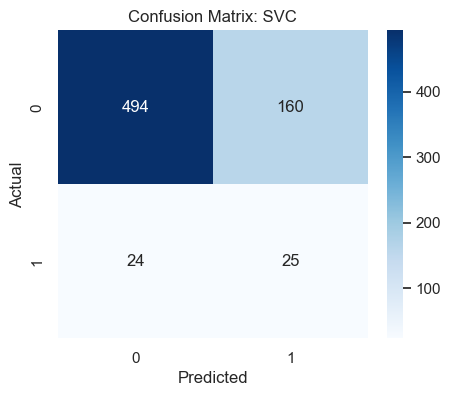

**********************************************************************************************
------------------/////////  DecisionTreeClassifier()  ////////---------
Model: DecisionTreeClassifier
Accuracy:  0.7539
Precision: 0.1026
Recall:    0.3265
F1 Score:  0.1561
AUC Score: 0.5562316669787181

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.79      0.86       654
           1       0.10      0.33      0.16        49

    accuracy                           0.75       703
   macro avg       0.52      0.56      0.51       703
weighted avg       0.88      0.75      0.81       703



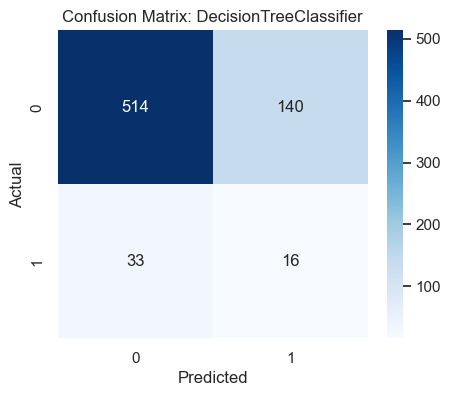

**********************************************************************************************
------------------/////////  RandomForestClassifier()  ////////---------
Model: RandomForestClassifier
Accuracy:  0.8450
Precision: 0.1429
Recall:    0.2449
F1 Score:  0.1805
AUC Score: 0.7371122761031016

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       654
           1       0.14      0.24      0.18        49

    accuracy                           0.84       703
   macro avg       0.54      0.57      0.55       703
weighted avg       0.88      0.84      0.86       703



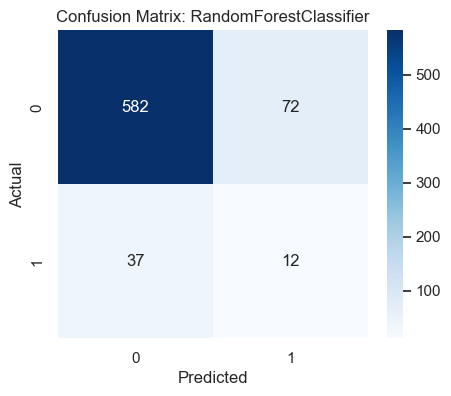

**********************************************************************************************
------------------/////////  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)  ////////---------
Model: XGBClassifier
Accuracy:  0.7155
Precision: 0.1584
Recall:    0.7143
F1

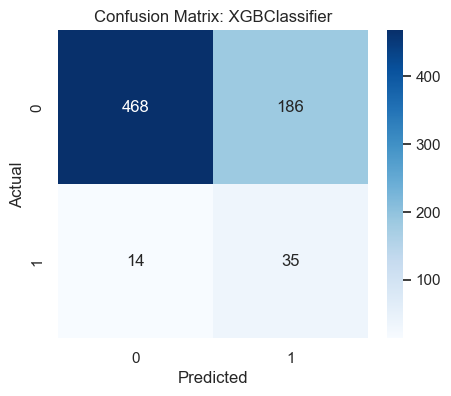

**********************************************************************************************


In [50]:

models = [
    LogisticRegression(max_iter=1000),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(eval_metric='logloss')
]

for model in models:
    print(f"------------------/////////  {model}  ////////---------")
    Classifier.evaluate_model(model, X_train_resampled, X_test_encoded, y_train_resampled, y_test)
    print("**********************************************************************************************")

## Confusion Matrix is confusing so I did for myself some reminder


- **True Negatives** (Top-Left Cell):  patients who did not have a stroke (Actual: 0) were correctly predicted as not having a stroke (Predicted: 0).
- **False Positives** (Top-Right Cell):  patients who did not have a stroke (Actual: 0) were incorrectly predicted as having a stroke (Predicted: 1). These are also known as Type I errors.
- **False Negatives** (Bottom-Left Cell): patients who did have a stroke (Actual: 1) were incorrectly predicted as not having a stroke (Predicted: 0). These are also known as Type II errors.
- **True Positives** (Bottom-Right Cell):  patients who did have a stroke (Actual: 1) were correctly predicted as having a stroke (Predicted: 1).

## Goodness of fit and reporting

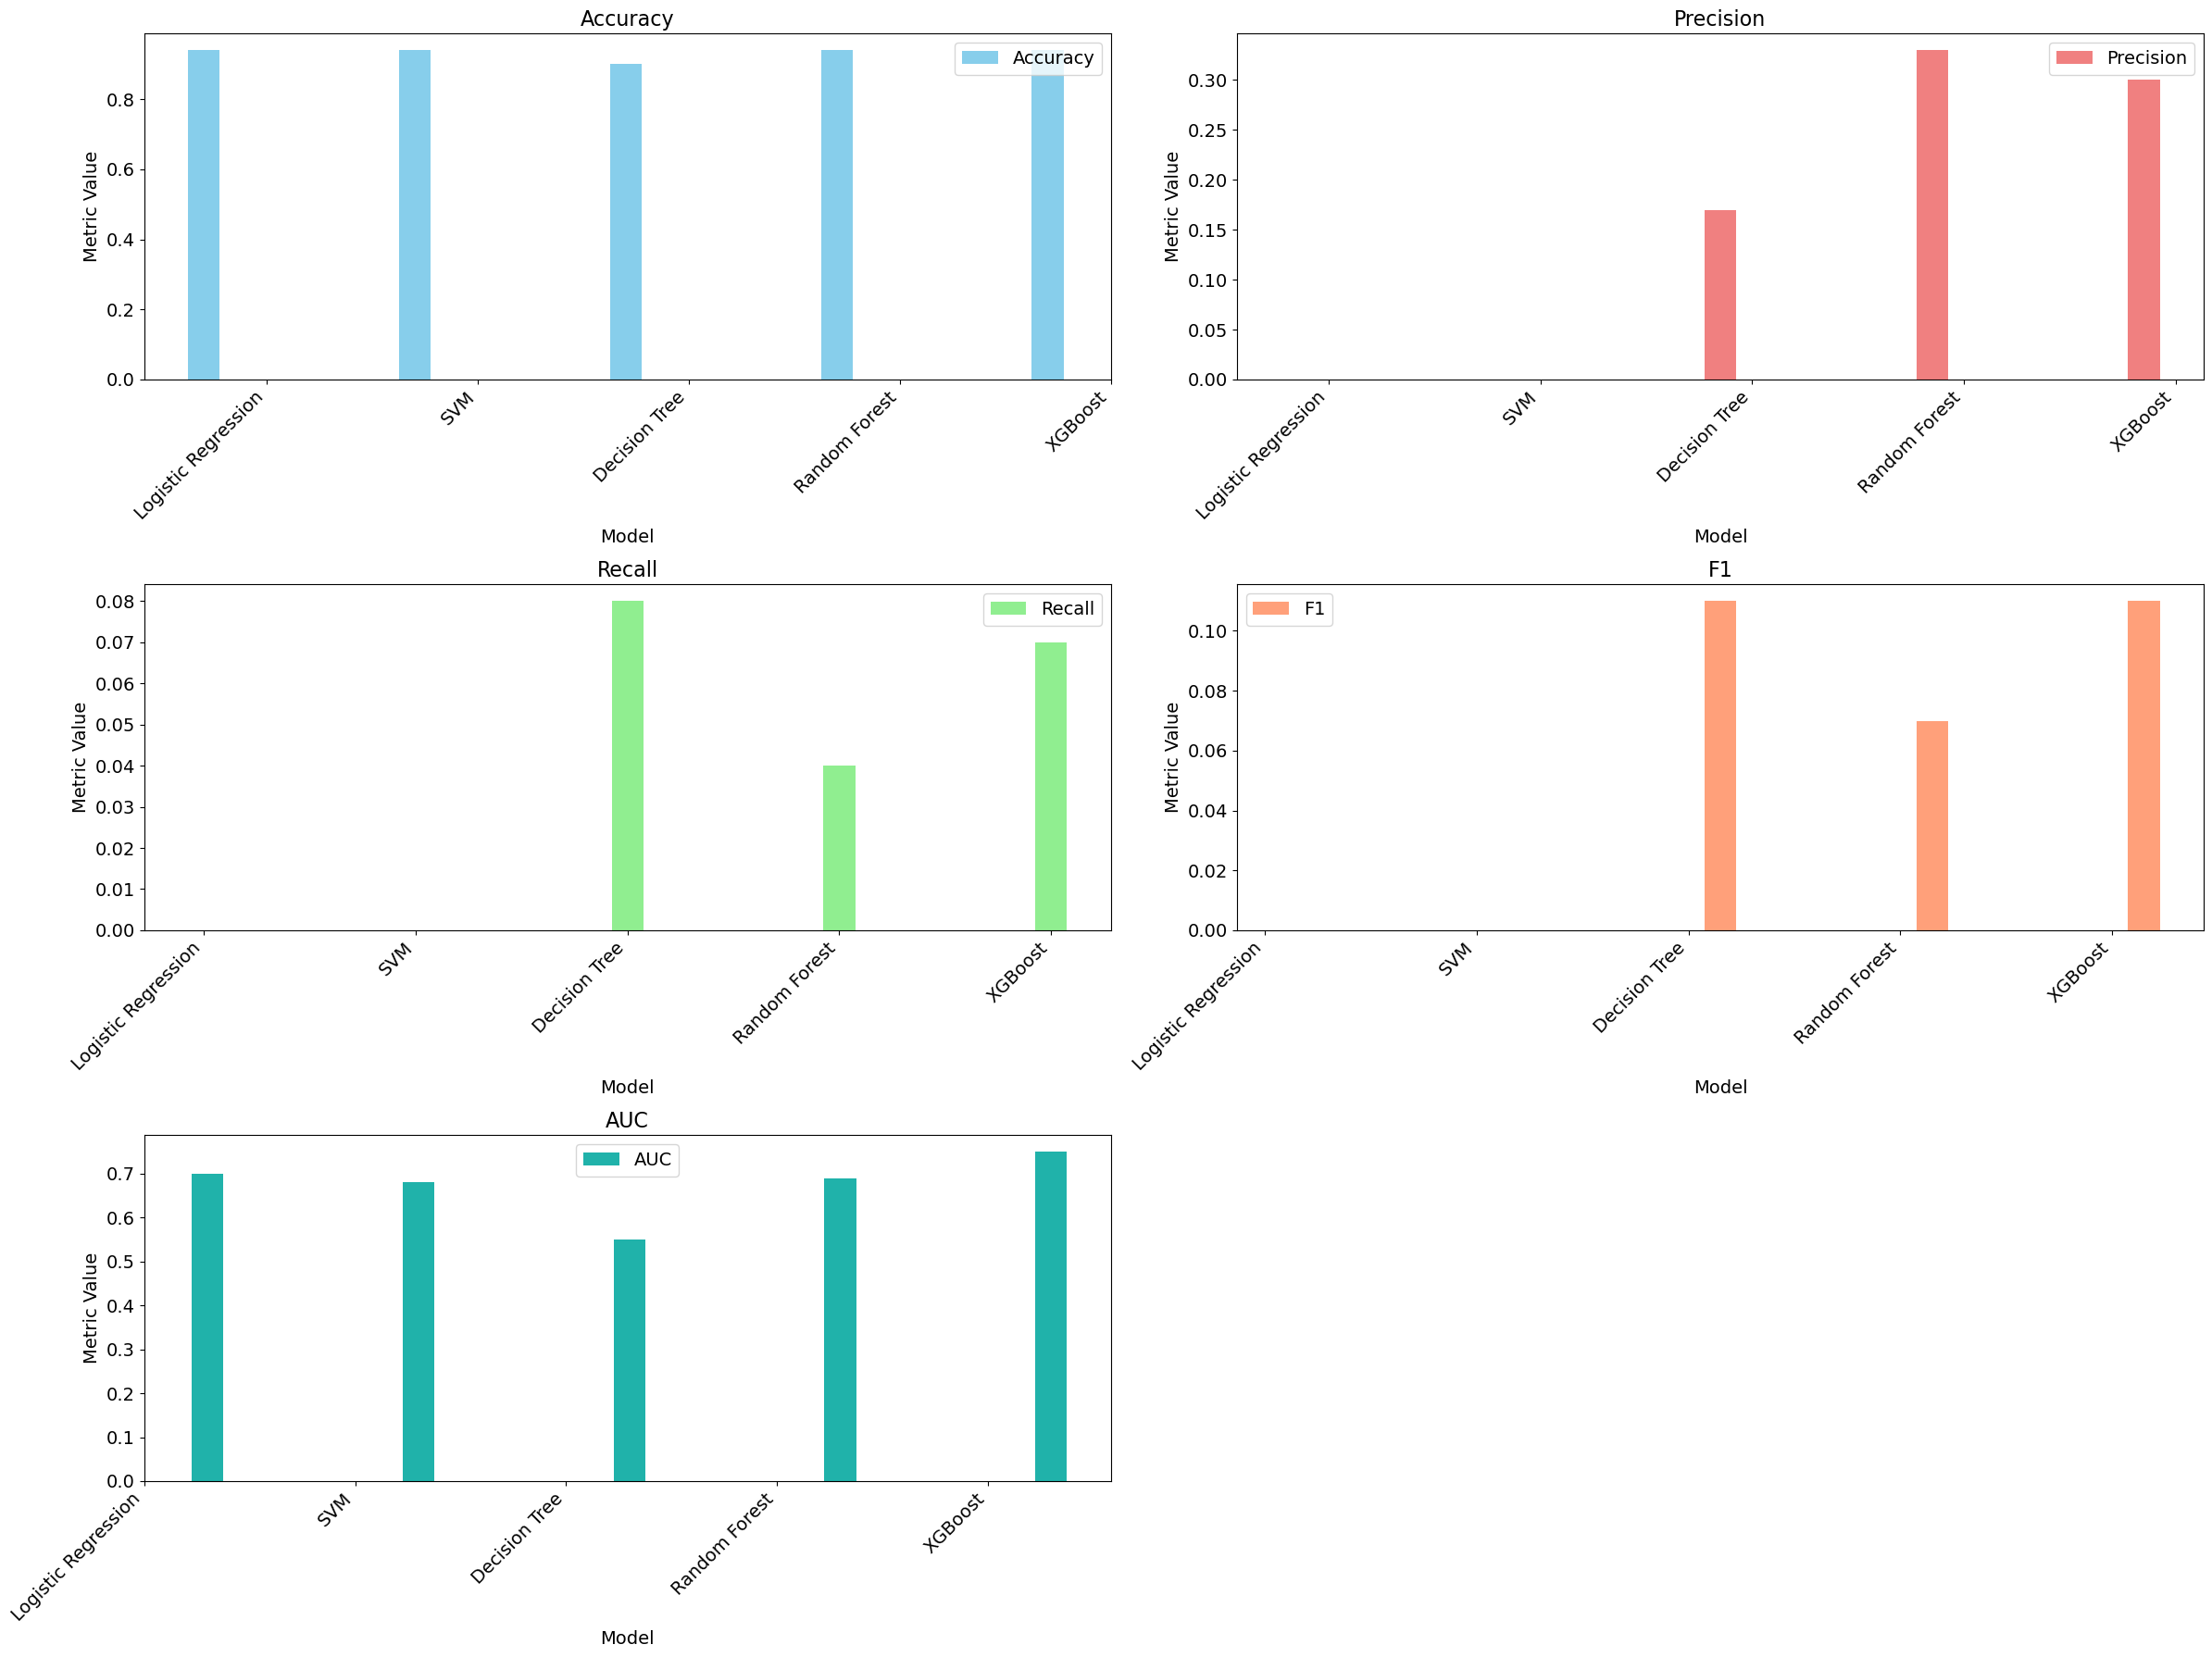

In [8]:
def plot_model_metrics_histogram_grid(model_names, metrics, values, n_cols=2, font_size=18):

    num_metrics = len(metrics)
    num_models = len(model_names)
    n_rows = int(np.ceil(num_metrics / n_cols))
    bar_width = 0.15
    index = np.arange(num_models)

    colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightseagreen']

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        metric_values = values[metric]
        for j, model_value in enumerate(metric_values):
            ax.bar(index[j] + i * bar_width, model_value, bar_width, color=colors[i % len(colors)],
                   label=metric if j == 0 else "")

        ax.set_xlabel('Model', fontsize=font_size)
        ax.set_ylabel('Metric Value', fontsize=font_size)
        ax.set_title(metric, fontsize=font_size + 2)  
        ax.set_xticks(index + bar_width * (num_metrics - 1) / 2)
        ax.set_xticklabels(model_names, rotation=45, ha="right", fontsize=font_size)
        ax.tick_params(axis='y', labelsize=font_size)  
        ax.legend(fontsize=font_size)

    for i in range(num_metrics, n_rows * n_cols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Example Usage (replace with your actual metric values)
model_names = ['Logistic Regression', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost']

# Ensure you have these values calculated from your model evaluations
metrics_values = {
    'Accuracy': [0.94, 0.94, 0.90, 0.94, 0.94],
    'Precision': [0.00, 0.00, 0.17, 0.33, 0.30],
    'Recall': [0.00, 0.00, 0.08, 0.04, 0.07],
    'F1': [0.00, 0.00, 0.11, 0.07, 0.11],
    'AUC': [0.70, 0.68, 0.55, 0.69, 0.75]
}

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
plot_model_metrics_histogram_grid(model_names, metrics_to_plot, metrics_values, n_cols=2, font_size=14)

<h2>Models Performance Result</h2>
<table border="1">
  <thead>
    <tr>
      <th>Model</th>
      <th>Accuracy</th>
      <th>Precision (Class 1)</th>
      <th>Recall (Class 1)</th>
      <th>F1-score (Class 1)</th>
      <th>AUC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Logistic Regression</td>
      <td>71%</td>
      <td>0.13</td>
      <td>0.59</td>
      <td>0.22</td>
      <td>0.73</td>
    </tr>
    <tr>
      <td>SVC</td>
      <td>74%</td>
      <td>0.14</td>
      <td>0.51</td>
      <td>0.21</td>
      <td>0.73</td>
    </tr>
    <tr>
      <td>Decision Tree</td>
      <td>75%</td>
      <td>0.10</td>
      <td>0.31</td>
      <td>0.15</td>
      <td>0.54</td>
    </tr>
    <tr>
      <td>Random Forest</td>
      <td>84%</td>
      <td>0.13</td>
      <td>0.22</td>
      <td>0.17</td>
      <td>0.74</td>
    </tr>
    <tr>
      <td>XGBClassifier</td>
      <td>72%</td>
      <td>0.16</td>
      <td>0.71</td>
      <td>0.26</td>
      <td>0.75</td>
    </tr>
  </tbody>
</table>

###   Model's Performance Explained:

* **Logistic Regression:**

    * **Accuracy**: Around 71%.
    * **Precision** (Class 1): 0.13 (Very low - poor positive predictive value for stroke cases).
    * **Recall** (Class 1): 0.59 (Moderate - good portion of actual stroke cases).
    * **F1-score** (Class 1): 0.22 (Low - poor balance between precision and recall).
    * **AUC**: 0.73 (Fair - moderate ability to distinguish between stroke and non-stroke).
    * **Comparison:** Logistic Regression shows a limited ability to accurately predict stroke cases, often misclassifying them. While it captures a                          decent fraction of actual stroke events, the high number of false positives is a significant concern.

* **SVC (Support Vector Classifier):**

    * **Accuracy**: Around 74% (Slightly better than Logistic Regression).
    * **Precision** (Class 1): 0.14 (Very low - similar issue with false positives).
    * **Recall (Class 1)**: 0.51 (Moderate - slightly lower stroke case capture than Logistic Regression).
    * **F1-score (Class 1)**: 0.21 (Low - similar poor balance).
    * **AUC: 0.73** (Fair - comparable to Logistic Regression).
    * **Comparison:** SVC offers a marginal improvement in overall accuracy over Logistic Regression but doesn't address the fundamental problem of low                       precision in stroke prediction. It's not a substantial improvement.

* **Decision Tree Classifier:**

    * **Accuracy**: Around 75%.
    * **Precision (Class 1)**: 0.10 (Very low - worst precision among all models).
    * **Recall (Class 1)**: 0.31 (Low - significantly reduced ability to detect stroke cases).
    * **F1-score (Class 1)**: 0.15 (Very low - poorest balance).
    * **AUC**: 0.54 (Poor - barely better than random guessing).
    * **Comparison:** The Decision Tree performs the worst in predicting stroke. Its low precision and recall, combined with a near-random AUC,                               indicate that it's not a reliable model for this task. It likely overfits the training data and fails to generalize.

* **Random Forest Classifier:**

    * **Accuracy**: Around 84% (Highest accuracy).
    * **Precision (Class 1)**: 0.13 (Very low).
    * **Recall (Class 1)**: 0.22 (Lowest recall).
    * **F1-score (Class 1)**: 0.17 (Low).
    * **AUC**: 0.74 (Fair - similar to Logistic Regression and SVC).
    * **Comparison:** Random Forest achieves the highest overall accuracy, which is misleading. It performs poorly in correctly identifying stroke                            cases (low recall) and has a similar issue with false positives (low precision) as the other models. Its high accuracy is driven                        by its excellent performance on the majority class (non-stroke), not by its ability to predict stroke.

* **XGBClassifier:**

    * **Accuracy**: Around 72%.
    * **Precision (Class 1)**: 0.16 (Highest precision).
    * **Recall (Class 1)**: 0.71 (Highest recall).
    * **F1-score (Class 1)**: 0.26 (Highest F1-score).
    * **AUC**: 0.75 (Highest AUC).
    * **Comparison:** XGBClassifier stands out as the best-performing model for stroke prediction. It achieves the best balance between precision and                         recall (highest F1-score) and has the highest ability to distinguish between classes (highest AUC). While its overall accuracy                          isn't the highest, its superior performance on the minority class is crucial in this context.

* **Conclusion:**

    * All models struggle with the imbalanced data, where there are less stroke cases than non-stroke cases. that is why low precision and F1-                scores for the stroke class.
    * Accuracy is considered as good result  (over 70% in all the models) but alone is not a good indicator of model performance in this scenario.            Models with high accuracy may not have good prediction for the minority class.
    * **------------------------------------------------------**
    * **XGBClassifier is the most promising model.**
    * **------------------------------------------------------**
      * It provides the best trade-off between precision and recall, which is essential for medical diagnosis.
      * High recall is important to minimize false negatives (missing actual stroke cases) 
      * higher precision reduces the number of false alarms.
